# Comparing model fitting with Sherpa, iminuit and Astropy
Axel Donath ([@adonath](https://github.com/adonath) on GitHub) - Python in Astronomy 2016, Seattle

Notebook available at: https://github.com/astropy/astropy-model-ideas

# Motiviation

Ideally we (and non astronomers as well...) would like to have a general purpose, flexible, Python modeling and fitting package...but this doesn't exist yet. 

On monday and today pros and cons of some available packages (Astropy, Sherpa, scipy.optimize, ...) were dicussed. As a first step forward it seemed to be a good option to create an interface between the Astropy models and existing fitting packages such as emcee or Sherpa. Prototypes and ideas will be collected in the following repository:

https://github.com/astropy/astropy-model-ideas

As some may not know the packages, I'd like compare their APIs and show their use with a simple example from the [astropy docs](http://docs.astropy.org/en/stable/modeling/).


In [20]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'ggplot'])

from astropy.stats import gaussian_fwhm_to_sigma

from IPython.display import Image

In [21]:
from astropy.modeling.models import Gaussian1D

def fake_data():    
    # Generate fake data
    np.random.seed(42)
    g1 = Gaussian1D(1, 0, 0.2)
    g2 = Gaussian1D(2.5, 0.5, 0.1)
    x = np.linspace(-1, 1, 200)
    y = g1(x) + g2(x) + np.random.normal(0., 0.2, x.shape)
    return x, y

def show_data(x, y):
    plt.figure(figsize=(11, 6))
    plt.plot(x, y, label='Data')
    plt.xlabel('Position')
    plt.ylabel('Flux')

In [22]:
x, y = fake_data()

# iminuit
* [Minuit](https://en.wikipedia.org/wiki/MINUIT) is a standard optimizer used in High Energy physics (CERN)
* Iminuit is an interactive IPython-friendly mimizer based on Minuit (http://iminuit.readthedocs.org/en/latest/index.html)
* GitHub: https://github.com/iminuit/iminuit
* API similiar to [emcee](http://dan.iel.fm/emcee/current/)
* API design:

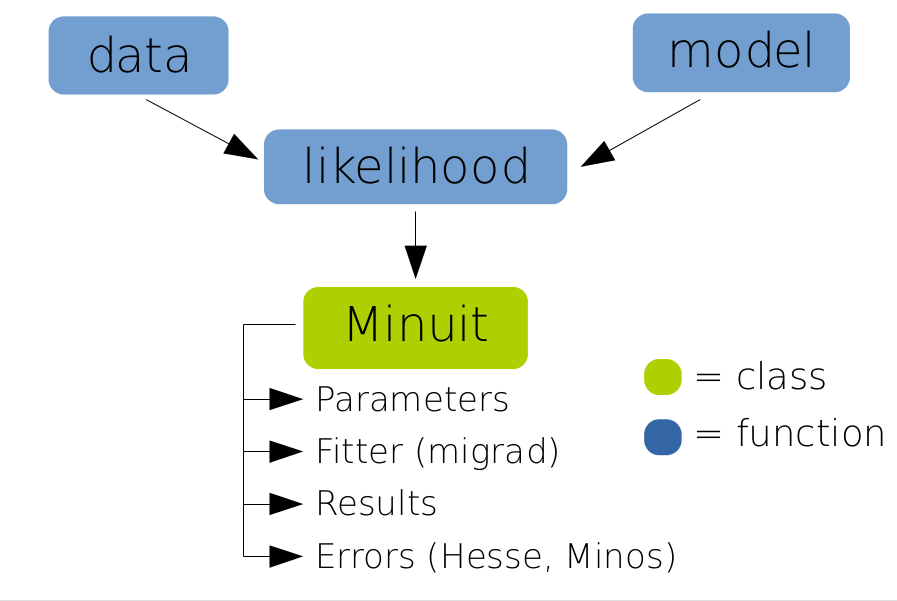

In [23]:
Image(filename='files/iminuit_api.png')

Fitting the data with iminuit:

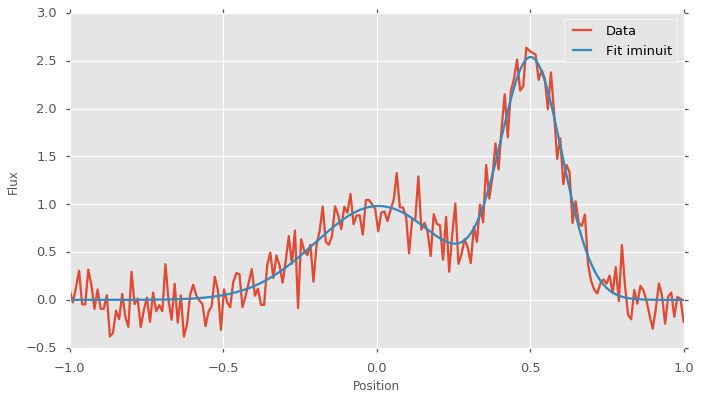

In [24]:
from iminuit import Minuit

def gauss(x, amplitude, mean, sigma):
    return amplitude * np.exp(- (x - mean) ** 2 / sigma ** 2)

def model_iminuit(x, amplitude_1, mean_1, sigma_1, amplitude_2, mean_2, sigma_2):
    model = gauss(x, amplitude_1, mean_1, sigma_1)
    model += gauss(x, amplitude_2, mean_2, sigma_2)
    return model

def neg_log_likelihood(amplitude_1, mean_1, sigma_1, amplitude_2, mean_2, sigma_2):
    leastsqr = (y - model_iminuit(x, amplitude_1, mean_1, sigma_1,
                                  amplitude_2, mean_2, sigma_2)) ** 2
    return leastsqr.sum()

par_values_minuit = dict(amplitude_1=1, mean_1=0, sigma_1=gaussian_fwhm_to_sigma,
                        amplitude_2=1, mean_2=0.5, sigma_2=gaussian_fwhm_to_sigma * 0.1)

# Set up fitter
fit_minuit = Minuit(neg_log_likelihood, print_level=0, **par_values_minuit)

# Run fit
result_minuit = fit_minuit.migrad()

# Show result
parameters_minuit = [fit_minuit.values[_] for _ in fit_minuit.parameters]
show_data(x, y)
plt.plot(x, model_iminuit(x, *parameters_minuit), label='Fit iminuit')
plt.legend(loc=0)

# Sherpa
* Sherpa is CIAO'S modeling and fitting application (http://cxc.cfa.harvard.edu/contrib/sherpa)
* On GitHub: https://github.com/sherpa/sherpa (became open source in 2015)
* Conda package available on channel https://conda.anaconda.org/sherpa 
* Open Issues:
    * Not compatible with Python 3 (WIP)
    * Low level API docs missing (WIP)
* API design:

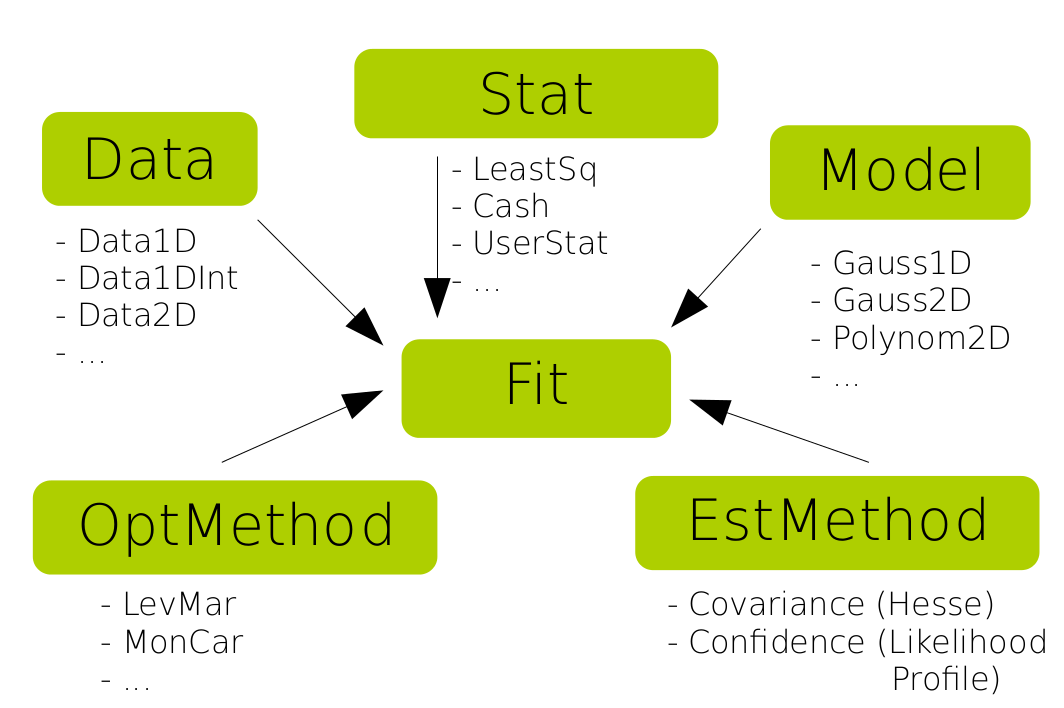

In [25]:
Image(filename='files/sherpa_api.png')

Fitting the example data with Sherpa:


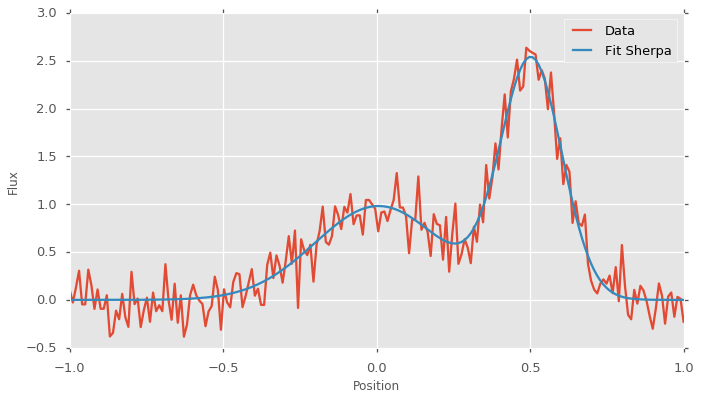

In [26]:
from sherpa.data import Data1D
from sherpa.models import Gauss1D
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar
from sherpa.fit import Fit

# Set up model and fit start parameters
g1_sherpa = Gauss1D('gauss_1')
g1_sherpa.ampl, g1_sherpa.fwhm, g1_sherpa.pos = 1, 1, 0

g2_sherpa = Gauss1D('gauss_2')
g2_sherpa.ampl, g2_sherpa.fwhm, g2_sherpa.pos = 2, 0.1, 0.5

model_sherpa = g1_sherpa + g2_sherpa

# Set up data container
data = Data1D('data', x=x, y=y)

# Set up fitter
fit_sherpa = Fit(data=data, model=model_sherpa, stat=LeastSq(),
                 method=LevMar())

# Run fit
result_sherpa = fit_sherpa.fit()

# Show result
show_data(x, y)
plt.plot(x, model_sherpa(x), label='Fit Sherpa')
plt.legend(loc=0)

# Astropy

* A Community Python Library for Astronomy (http://www.astropy.org/)
* On GitHub: https://github.com/astropy/astropy


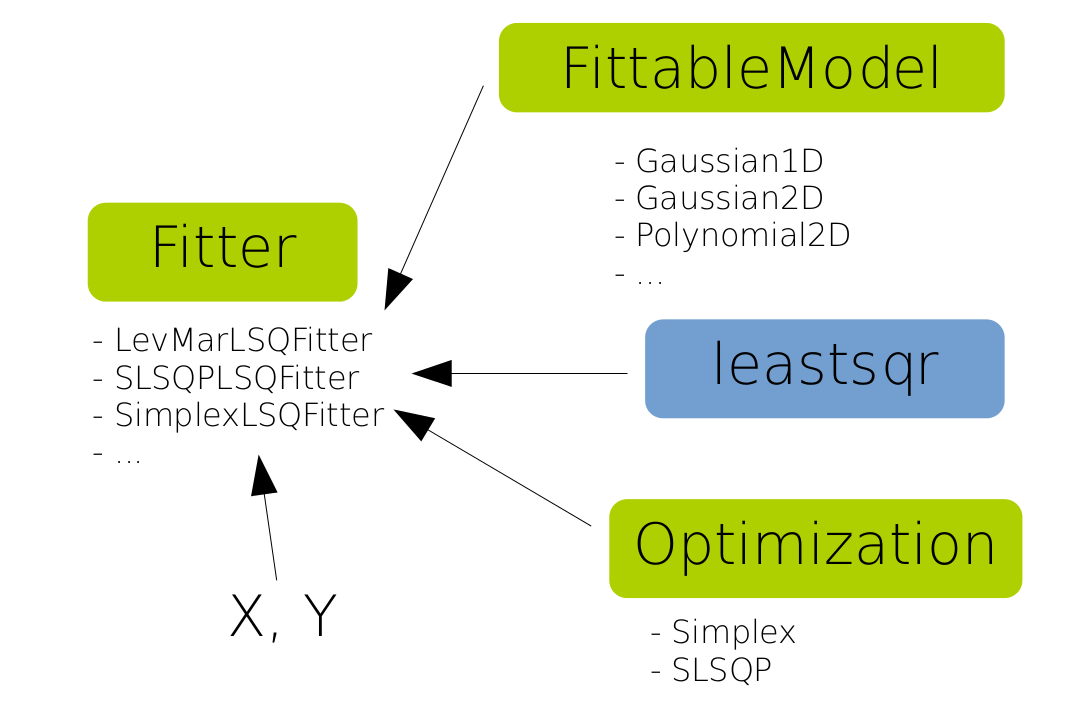

In [27]:
Image(filename='files/astropy_api.png')

In [28]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

# Set up model and fit start parameters
g1_astropy = Gaussian1D(1, 0, gaussian_fwhm_to_sigma * 1)
g2_astropy = Gaussian1D(2, 0.5, gaussian_fwhm_to_sigma * 0.1)

model_astropy = g1_astropy + g2_astropy

# Set up fitter
fit_astropy = LevMarLSQFitter()

# Run fit
result_astropy = fit_astropy(model_astropy, x, y)

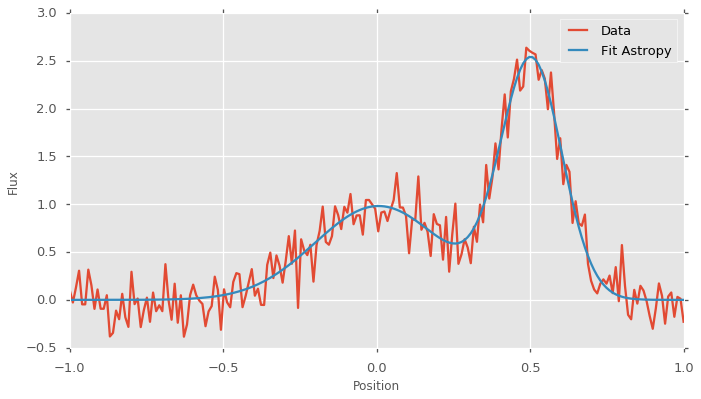

In [29]:
# Plot astropy result

show_data(x, y)
plt.plot(x, result_astropy(x), label='Fit Astropy')
plt.legend(loc=0)

# Feature comparison table

|              | iminuit  | Sherpa | Astropy 
|--------------|----------|--------|--------- 
|Model Language|   No     |   Yes  |   Yes    
|Fit Statistics|   Any you are able to implement yourself...   | Cash, CStat, LeastSq, Chi2, UserStat, WStat, ... |  leastsqr |
|Optimizers    | Migrad  | GridSearch, LevMar, MonCar, NelderMead  | Simplex, SLSQPL
|Error Estimation| Hesse, Minos (Likelihood Profiles) | Covariance (Hesse), Confidence (Likelihood Profiles) | covariance (Hesse)
|Handle derivatives| Yes | No | Yes


# Conclusion
The example shown above was very simple.

What if you'd like to do Poisson Maximum Likelihood fitting or take errors on data into account or try different optimizers, or take priors into account, or fit much more complicated models, or do an MC analysis...?


Non of the existing packages provides an easy to use and complete solution. As a first step it was suggested to create an interface between existing packages. Prototypes and ideas will be collected in:   

https://github.com/astropy/astropy-model-ideas